In [1]:
# Step 1: Install Required Libraries
# Let's make sure we have all required libraries installed in Google Colab, especially PySpark
!pip install pyspark kagglehub

In [2]:
import kagglehub
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

In [3]:
# Step 3: Load the Data from Kaggle
# Download the dataset using Kaggle API through KaggleHub, which simplifies access to datasets.
path = kagglehub.dataset_download("arjunbhasin2013/ccdata")
print("Path to dataset files:", path)

100%|██████████| 340k/340k [00:00<00:00, 55.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/arjunbhasin2013/ccdata/versions/1


In [4]:
# Step 4: Initialize Spark Session
# Starting a Spark session is essential to work with PySpark.
# This session allows us to create and process DataFrames.
spark = SparkSession.builder.appName("CreditCardClustering").getOrCreate()

In [8]:
# Step 5: Load Dataset into a Spark DataFrame and Display First Five Rows
# Loading the CSV data into a Spark DataFrame and showing a preview of the data.
data = spark.read.csv(path + '/CC GENERAL.csv', header=True, inferSchema=True)
data.show(5)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
| C10001|  40.900749|         0.818182|     95.4|             0.0|                  95.4|  

In [9]:
# Step 6: Data Preprocessing
# We will select relevant columns and handle any missing values by imputing or removing.
# Then, we will convert the features into a single vector column required by PySpark’s MLlib.

# Dropping columns with too many null values or impute them as needed
data = data.dropna()  # Simplified example; custom imputation may be more appropriate

# Selecting only numerical columns for clustering
feature_columns = [col for col in data.columns if col != "CUST_ID"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Standardize the features for better performance in clustering
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
data = scaler.fit(data).transform(data)

In [24]:
# Step 7: Apply K-Means Clustering
# K-means is often a go-to algorithm for segmentation as it forms well-defined clusters
# based on minimizing variance within clusters.

# Define the number of clusters
kmeans = KMeans(featuresCol="scaled_features", predictionCol="prediction", k=2)
model = kmeans.fit(data)
predictions = model.transform(data)

In [25]:
# Step 8: Evaluate Model Performance with Silhouette Score
# Silhouette score is a common metric for clustering quality; higher scores indicate better-defined clusters.

evaluator = ClusteringEvaluator(featuresCol="scaled_features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.4499350209986533


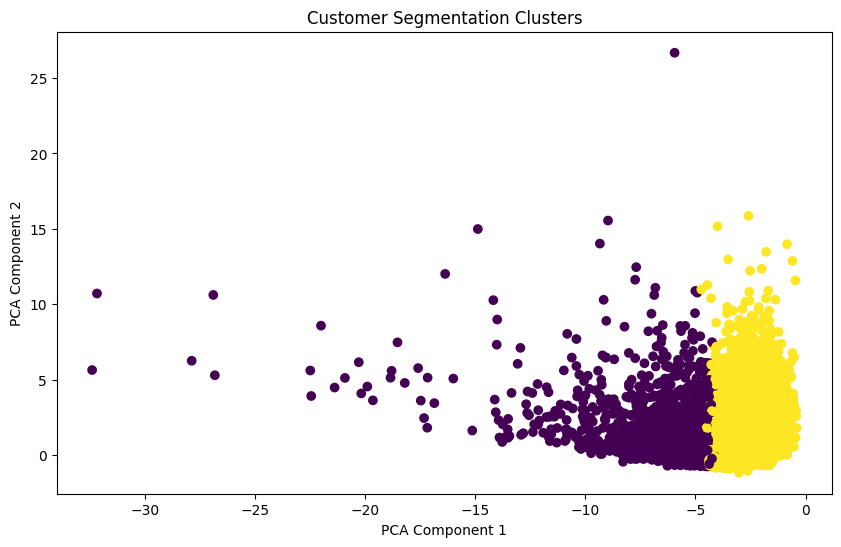

In [26]:
# Step 9: Visualize Clustering Results
# We’ll plot clusters to gain insights into customer segments. Since we have high-dimensional data,
# we’ll reduce dimensions using PCA for visualization purposes.
import pandas as pd
from pyspark.ml.feature import PCA

# Reducing dimensions to 2 for visualization
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(data)
pca_result = pca_model.transform(predictions)

# Converting PCA results to Pandas DataFrame for plotting
pca_df = pca_result.select("pca_features", "prediction").toPandas()
pca_df[["x", "y"]] = pd.DataFrame(pca_df["pca_features"].tolist(), index=pca_df.index)

# Plotting clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_df["x"], pca_df["y"], c=pca_df["prediction"], cmap="viridis")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Customer Segmentation Clusters")
plt.show()

In [23]:
for k in range(2, 8):
    kmeans = KMeans(featuresCol="scaled_features", predictionCol="prediction", k=k)
    model = kmeans.fit(data)
    predictions = model.transform(data)
    silhouette = evaluator.evaluate(predictions)
    print(f"Silhouette Score for k={k}: {silhouette}")

Silhouette Score for k=2: 0.4499350209986533
Silhouette Score for k=3: 0.26990506114925067
Silhouette Score for k=4: 0.2911791829710855
Silhouette Score for k=5: 0.24658395290713725
Silhouette Score for k=6: 0.2870461519445393
Silhouette Score for k=7: 0.26422961171639725


Silhouette Score with GMM for k=4: 0.281568992560273


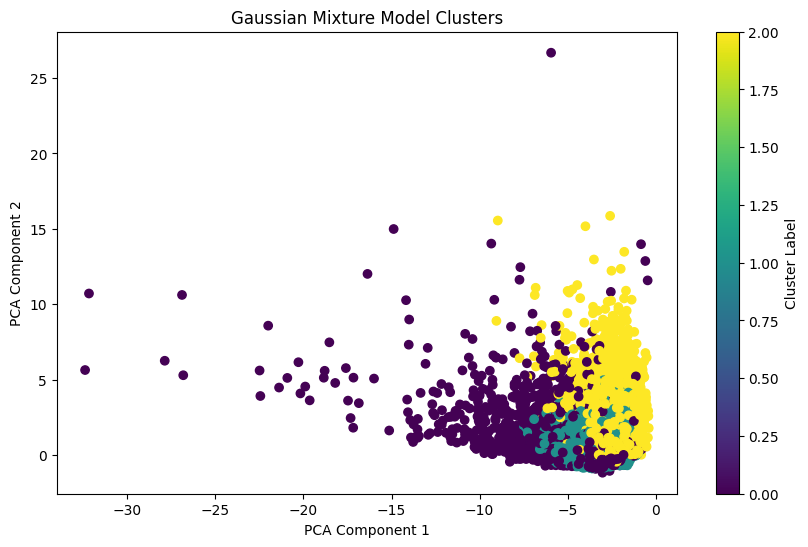

In [31]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Apply Gaussian Mixture Model Clustering
gmm = GaussianMixture(featuresCol="scaled_features", k=3)  # Adjust 'k' based on experiments
gmm_model = gmm.fit(data)
gmm_predictions = gmm_model.transform(data)


silhouette = evaluator.evaluate(gmm_predictions)
print(f"Silhouette Score with GMM for k=4: {silhouette}")

# Step 2: Reduce Dimensions Using PCA for Visualization
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(data)
pca_result = pca_model.transform(gmm_predictions)

# Step 3: Convert PCA results to Pandas DataFrame for easier plotting
pca_df = pca_result.select("pca_features", "prediction").toPandas()
pca_df[["x", "y"]] = pd.DataFrame(pca_df["pca_features"].tolist(), index=pca_df.index)

# Step 4: Plot Clusters with Matplotlib
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df["x"], pca_df["y"], c=pca_df["prediction"], cmap="viridis")
plt.colorbar(scatter, label="Cluster Label")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Gaussian Mixture Model Clusters")
plt.show()

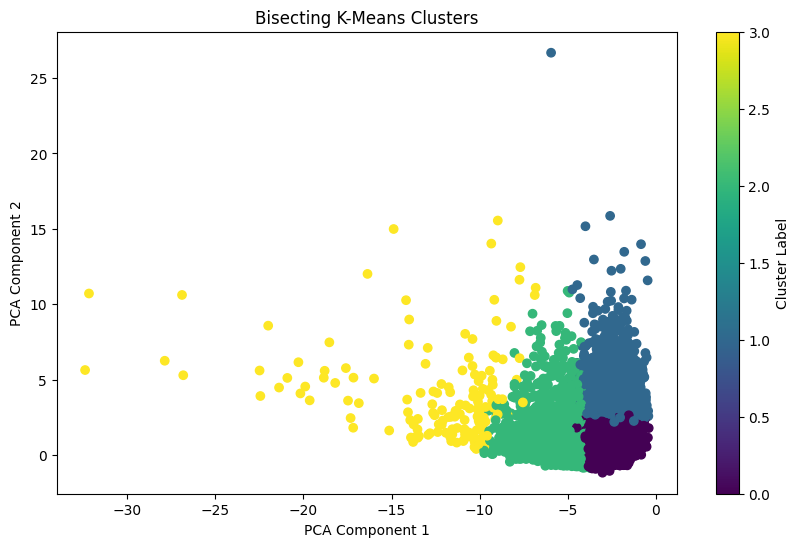

Silhouette Score for Bisecting K-Means: 0.31011820962783637


In [32]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Bisecting K-Means Clustering
bkmeans = BisectingKMeans(featuresCol="scaled_features", k=4)  # Adjust 'k' based on evaluation needs
bkmeans_model = bkmeans.fit(data)
bkmeans_predictions = bkmeans_model.transform(data)

# Reduce Dimensions Using PCA for Visualization
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(data)
pca_result = pca_model.transform(bkmeans_predictions)

# Convert PCA results to Pandas DataFrame
pca_df = pca_result.select("pca_features", "prediction").toPandas()
pca_df[["x", "y"]] = pd.DataFrame(pca_df["pca_features"].tolist(), index=pca_df.index)

# Plot Bisecting K-Means Clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_df["x"], pca_df["y"], c=pca_df["prediction"], cmap="viridis")
plt.colorbar(label="Cluster Label")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Bisecting K-Means Clusters")
plt.show()

# Evaluate using Silhouette Score
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator(featuresCol="scaled_features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette_bkmeans = evaluator.evaluate(bkmeans_predictions)
print(f"Silhouette Score for Bisecting K-Means: {silhouette_bkmeans}")

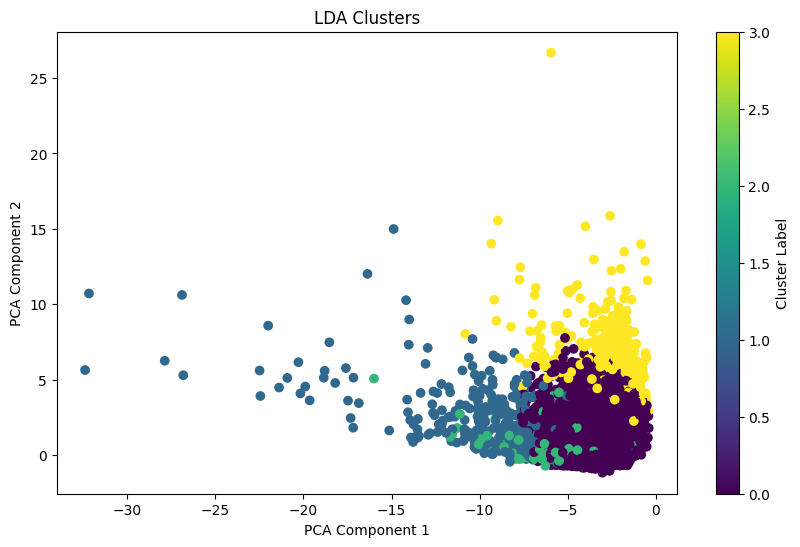

In [34]:
from pyspark.ml.clustering import LDA
import numpy as np
# LDA Clustering
lda = LDA(featuresCol="scaled_features", k=4, maxIter=10)  # Adjust 'k' and 'maxIter' as needed
lda_model = lda.fit(data)
lda_predictions = lda_model.transform(data)

# Reduce Dimensions Using PCA for Visualization
pca_result = pca_model.transform(lda_predictions)

# Convert PCA results to Pandas DataFrame
pca_df = pca_result.select("pca_features", "topicDistribution").toPandas()
pca_df[["x", "y"]] = pd.DataFrame(pca_df["pca_features"].tolist(), index=pca_df.index)

# For visualization, assign each point to the topic with the highest probability
pca_df["prediction"] = pca_df["topicDistribution"].apply(lambda x: np.argmax(x))

# Plot LDA Clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_df["x"], pca_df["y"], c=pca_df["prediction"], cmap="viridis")
plt.colorbar(label="Cluster Label")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("LDA Clusters")
plt.show()

# LDA does not directly support Silhouette score, but you can evaluate coherence or inter-cluster variance if needed.

In [ ]:
from pyspark.ml.clustering import PowerIterationClustering
from pyspark.sql import Row
import numpy as np



from pyspark.ml.clustering import PowerIterationClustering
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Create a Spark session
spark = SparkSession.builder.appName("Credit Card Clustering").getOrCreate()

# Assuming `data` already contains the scaled features and necessary transformations.

# Step 1: Create an Edge DataFrame for Power Iteration Clustering
# Getting features as an array for distance calculations
features = data.select("scaled_features").collect()
n = len(features)

# Create edges based on distances (using Euclidean distance)
edges = []
for i in range(n):
    for j in range(i + 1, n):  # Only create edges for unique pairs
        # Calculate the Euclidean distance using PySpark functions
        dist = float(Vectors.squared_distance(features[i][0], features[j][0])) ** 0.5
        edges.append((i, j, dist))  # Add source, destination, and weight

# Create DataFrame for edges
edges_df = spark.createDataFrame(edges, ["src", "dst", "weight"])

# Step 2: Apply Power Iteration Clustering
pic = PowerIterationClustering(k=4, maxIter=20, initMode="random")  # Adjust 'k' based on needs
pic_model = pic.assignClusters(edges_df)
pic_predictions = pic_model.toDF("src", "prediction")

# Join with original data to visualize
predicted_data = data.select("CUST_ID").rdd.zipWithIndex().toDF(["CUST_ID", "id"]).join(pic_predictions, pic_predictions.src == "id").drop("id")

# Step 3: Visualize PIC Clusters with PCA
# Re-using PCA transformation from GMM or GMM
pca_result = pca_model.transform(predicted_data)  # Reuse PCA transformation for visualization

# Convert to Pandas DataFrame for plotting
pca_df = pca_result.select("pca_features", "prediction").toPandas()
pca_df[["x", "y"]] = pd.DataFrame(pca_df["pca_features"].tolist(), index=pca_df.index)

# Plot PIC Clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_df["x"], pca_df["y"], c=pca_df["prediction"], cmap="viridis")
plt.colorbar(label="Cluster Label")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Power Iteration Clustering Clusters")
plt.show()

# Note: PIC does not have a straightforward silhouette score; visualization can help assess cluster quality.